# Differentially Private Maps Demo

First, importing some libraries I'll need.

In [3]:
#@title Click for code
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace
import ipywidgets as widgets
from ipywidgets import interactive

Matplotlib is building the font cache; this may take a moment.


Let's say we've already generated a histogram of counts, which we want to make private. Here I'll do things at the state level, and am generating some fake data that represents the underlying true counts.

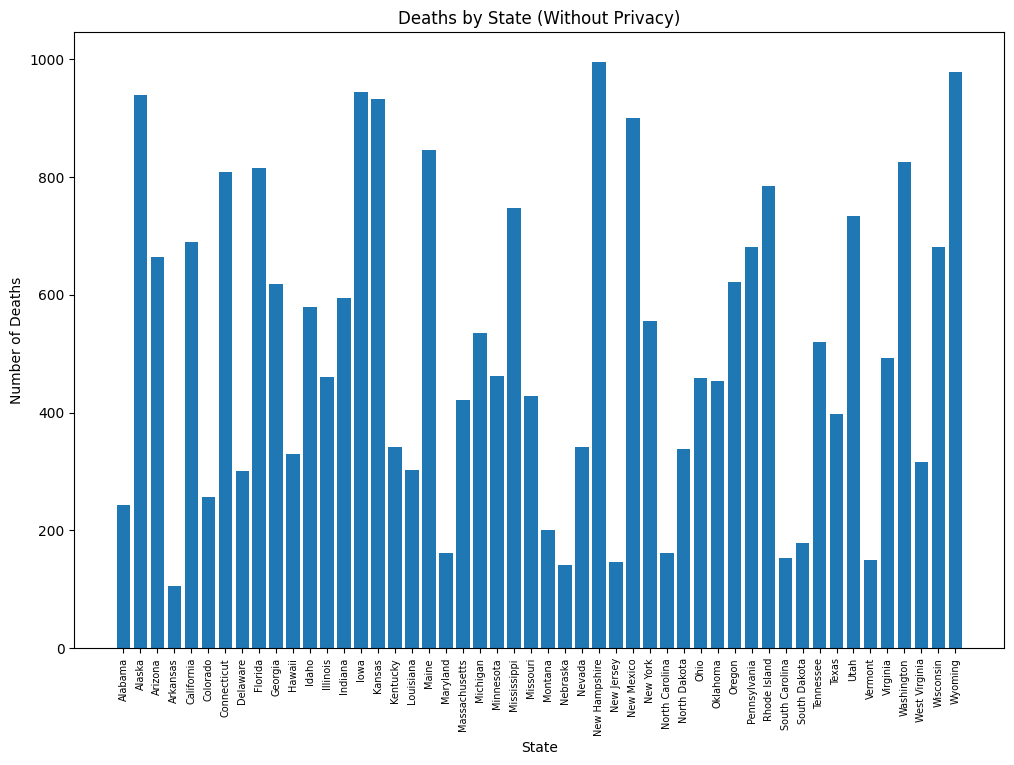

In [4]:
#@title Click for code

us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
    'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
    'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
    'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
    'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
    'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
    'West Virginia', 'Wisconsin', 'Wyoming'
]

counts = np.random.randint(low=100,high=1000,size=50)

plt.figure(figsize=(12,8))
plt.bar(us_states, counts)
plt.xticks(rotation=90, ha='center', fontsize=7) #rotating the names to vertical
plt.xlabel("State")
plt.ylabel("Number of Deaths")
plt.title("Deaths by State (Without Privacy)");

Now, we need to add noise to make it private. First, we need to pick the privacy parameter. For the simplest approach, we'll add noise scaled by Lap(1/ɛ). To visualize how much noise you'll end up adding to the counts, here's the distribution as scaled by epsilon. When epsilon is much smaller than 1, you end up adding large amounts to the counts, and when it is bigger than 1, you add very small amounts to the counts, e.g. less than 1.

In [5]:
#@title Click for code

# Function to plot Laplace distribution
def plot_laplace(epsilon):
    x = np.linspace(-10, 10, 1000)
    y = laplace.pdf(x, scale=1/epsilon)
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=f'epsilon={1/epsilon}')
    plt.title('Laplace Distribution PDF')
    plt.xlabel('x')
    plt.ylabel('PDF')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create an interactive slider for scale
scale_slider = widgets.FloatSlider(value=1.0, min=0.1, max=20.0, step=0.5, description='Epsilon:', continuous_update=False)

# Create the interactive plot
interactive_plot = interactive(plot_laplace, epsilon=scale_slider)

# Display the interactive plot with the slider
display(interactive_plot)

Now, you need to pick your value of epsilon, which you can enter here.

In [ ]:
#@title Click for code

# Define a function to handle the input and store it in a variable
def handle_submit(change):
    global epsilon
    epsilon = float(change['new'])

# Create a text input widget
text_widget = widgets.Text(
    value='',
    description='Epsilon:',
    disabled=False
)

# Attach the handler to the text input widget
text_widget.observe(handle_submit, names='value')

# Display the widget
display(text_widget)

Text(value='', description='Epsilon:')

Next, we use this value of epsilon to generate random Laplace noise scaled by it, and we'll add this random noise to each bin of the histogram.

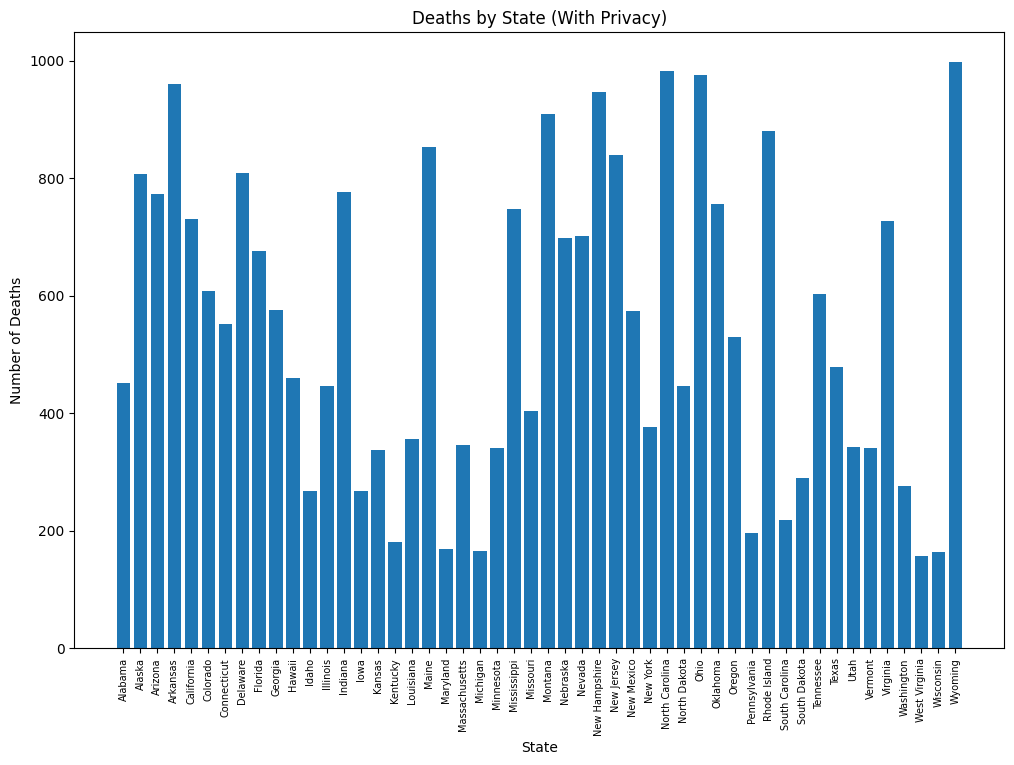

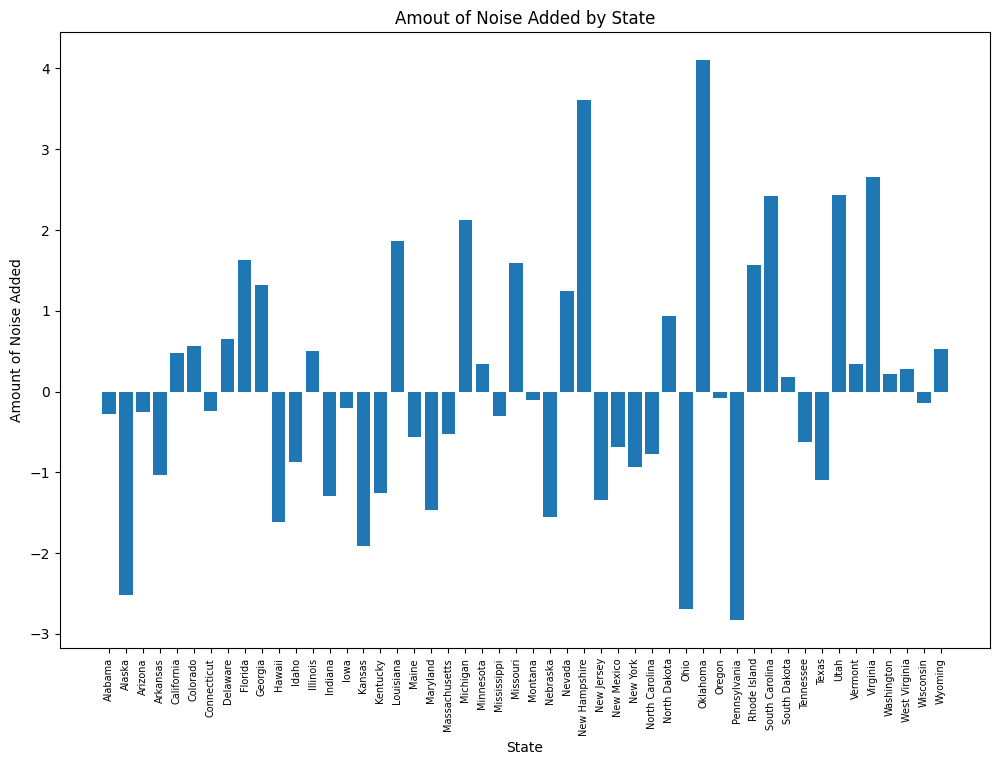

In [ ]:
#@title Click for code

noise = np.random.laplace(scale=1/epsilon, size=50)
noisy_counts = counts + noise

plt.figure(figsize=(12,8))
plt.bar(us_states, noisy_counts)
plt.xticks(rotation=90, ha='center', fontsize=7) #rotating the names to vertical
plt.xlabel("State")
plt.ylabel("Number of Deaths")
plt.title("Deaths by State (With Privacy)");

plt.figure(figsize=(12,8))
plt.bar(us_states, noise)
plt.xticks(rotation=90, ha='center', fontsize=7) #rotating the names to vertical
plt.xlabel("State")
plt.ylabel("Amount of Noise Added")
plt.title("Amout of Noise Added by State");


Finally, can use the noisy counts to generate a map over all the states of the noisy counts.

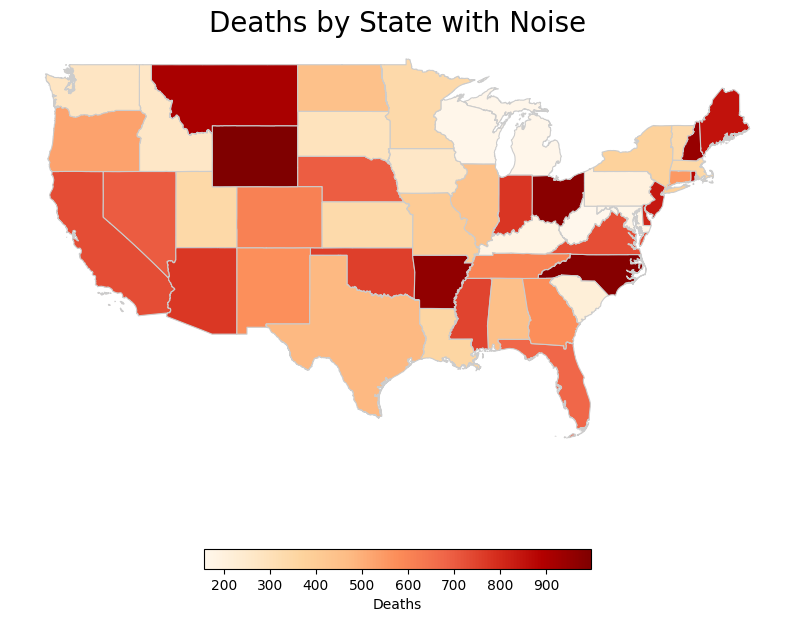

In [114]:
#@title Click for code
# Load US states shapefile

count_df = pd.DataFrame({'NAME': us_states, 'COUNTS': noisy_counts})
gdf = gpd.read_file("drive/MyDrive/US_State_Data")

gdf.head()
merged_df = pd.merge(gdf, count_df, on='NAME', how='inner')
merged_df = merged_df[merged_df['NAME']!='Alaska'] #getting rid because they make the map look weird
merged_df = merged_df[merged_df['NAME']!='Hawaii']

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_df.plot(column='COUNTS', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
               legend_kwds={'shrink': 0.5, 'label': "Deaths", 'orientation': "horizontal"})
ax.axis('off')
ax.set_title('Deaths by State with Noise', fontsize=20)
plt.show()